In [8]:
import os
import laspy as lp
import numpy as np
import pylas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
import pandas as pd

In [10]:
#Leser filer fra eksempelmappen og plotter punktskyene- ser at vi får tak 


folder = "sample_roofdata_50"

# Opprett en tom dictionary for å lagre informasjonen
roofs_dict = {}
roofs_data = []

df = gpd.GeoDataFrame()
# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        # Lag hele filstien ved å kombinere mappen og filnavnet
        file_path = os.path.join(folder, roof)
        
        # Åpne .laz-filen og hent informasjon
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            point_count = fh.header.point_count
          
            
            
            # Legg til informasjon i dictionary
            roofs_dict[roof] = {
                "point_count": point_count
            }

            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z

            roofs_data.append({
                "file_name": roof,        
                "point_count": point_count,
                "x": x,        
                "y": y,         
                "z": z,      

            })
            

        #fig = plt.figure(figsize=(10, 7))
        #ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(x, y, z, s=1, c=z, cmap='viridis')  # s=1 betyr små punkter, c=z farger punktene basert på høyde
        #ax.set_title(f"Punktsky: {roof}")
        #ax.set_xlabel("X")
        #ax.set_ylabel("Y")
        #ax.set_zlabel("Z")
        #plt.show()
        #break #hvis du vil se alle 50 takene, fjern denne 


# Skriv ut dictionary for å verifisere
print(roofs_dict)

df = pd.DataFrame(roofs_data)
df

{'182130478.laz': {'point_count': 1431}, '10566010.laz': {'point_count': 610}, '182250287.laz': {'point_count': 2762}, '182213209.laz': {'point_count': 3732}, '182461407.laz': {'point_count': 1463}, '182380105.laz': {'point_count': 2242}, '182251615.laz': {'point_count': 3642}, '182221864.laz': {'point_count': 3215}, '182486507.laz': {'point_count': 7653}, '182251399.laz': {'point_count': 4449}, '10565839.laz': {'point_count': 514}, '182307580.laz': {'point_count': 1702}, '182294063.laz': {'point_count': 1494}, '10529360.laz': {'point_count': 2571}, '182292761.laz': {'point_count': 1134}, '10479436.laz': {'point_count': 1571}, '182311324.laz': {'point_count': 4134}, '182217581.laz': {'point_count': 2518}, '182461857.laz': {'point_count': 3411}, '182379476.laz': {'point_count': 2605}, '300426167.laz': {'point_count': 895}, '182218669.laz': {'point_count': 4005}, '182274798.laz': {'point_count': 4121}, '10529379.laz': {'point_count': 2561}, '182172235.laz': {'point_count': 18538}, '21028

,file_name,point_count,x,y,z
0,182130478.laz,1431,"[574233.04, 574233.29, 574233.55, 574232.86, 5...","[7035248.890000001, 7035249.4, 7035249.91, 703...","[21.0, 20.57, 20.080000000000002, 22.61, 22.12..."
1,10566010.laz,610,"[571975.54, 571975.3200000001, 571975.09, 5719...","[7030582.08, 7030581.68, 7030581.26, 7030581.2...","[132.32, 132.18, 132.04, 132.04, 132.53, 132.2..."
2,182250287.laz,2762,"[571158.34, 571158.62, 571158.86, 571159.11, 5...","[7032974.55, 7032975.08, 7032975.57, 7032976.0...","[119.38, 119.05, 118.73, 118.41, 119.42, 119.0..."
3,182213209.laz,3732,"[570541.56, 570540.83, 570539.9, 570538.23, 57...","[7033708.16, 7033707.86, 7033707.5, 7033706.82...","[60.94, 60.63, 60.61, 60.69, 60.71, 60.71, 60...."
4,182461407.laz,1463,"[566638.55, 566638.33, 566638.13, 566637.72, 5...","[7025571.65, 7025571.23, 7025570.83, 7025570.0...","[184.47, 184.24, 184.31, 183.75, 183.52, 183.3..."
5,182380105.laz,2242,"[571962.4500000001, 571962.24, 571962.57000000...","[7030503.01, 7030502.62, 7030504.57, 7030504.1...","[142.9, 142.70000000000002, 143.44, 143.3, 143..."
6,182251615.laz,3642,"[570979.5700000001, 570980.18, 570980.39, 5709...","[7033239.05, 7033239.0200000005, 7033239.41, 7...","[121.48, 121.68, 121.94, 121.60000000000001, 1..."
7,182221864.laz,3215,"[571822.48, 571823.98, 571823.79, 571823.59, 5...","[7033837.57, 7033838.15, 7033837.76, 7033837.3...","[93.81, 94.14, 93.89, 93.61, 94.83, 94.5700000..."
8,182486507.laz,7653,"[566933.9500000001, 566933.58, 566933.87, 5669...","[7024421.37, 7024421.05, 7024422.13, 7024421.8...","[150.21, 150.3, 149.71, 150.05, 150.3900000000..."
9,182251399.laz,4449,"[571074.1900000001, 571074.41, 571074.87, 5710...","[7033149.51, 7033149.94, 7033150.850000001, 70...","[123.08, 123.11, 123.18, 123.25, 122.97, 122.9..."


In [2]:
##kjapt generert for mer info


import os
import laspy as lp
import matplotlib.pyplot as plt

folder = "sample_roofdata_50"

# Opprett en tom dictionary for å lagre informasjonen
roofs_dict = {}

# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        # Lag hele filstien
        file_path = os.path.join(folder, roof)
        
        # Åpne .laz-filen og hent informasjon
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            header = fh.header
            point_count = header.point_count
            
            # Hent header-informasjon
            roofs_dict[roof] = {
                "file_path": file_path,
                "point_count": point_count,
                "version": f"{header.version.major}.{header.version.minor}",
                "point_format": header.point_format.id,
                "scale": header.scales,
                "offset": header.offsets,
                "min_bounds": header.mins,
                "max_bounds": header.maxs,
                "z-høyde": header.maxs[2],

            }
            
            # Les punktskydata
            laz_data = fh.read()
            x = laz_data.x
            y = laz_data.y
            z = laz_data.z

            ground_classification = laz_data.lasground
            print(ground_classification)
            #intensity = las_data.intensity if "intensity" in las_data.point_format else None
            #classification = las_data.classification if "classification" in las_data.point_format else None
            
            
        ## Plot punktsky i 3D
        #fig = plt.figure(figsize=(10, 7))
        #ax = fig.add_subplot(111, projection='3d')
        #scatter = ax.scatter(x, y, z, s=1, c=z, cmap='viridis')  # Fargepunkter basert på Z
        #ax.set_title(f"Punktsky: {roof}")
        #ax.set_xlabel("X")
        #ax.set_ylabel("Y")
        #ax.set_zlabel("Z")
        #plt.colorbar(scatter, label="Høyde (Z)")
        #plt.show()
        #
        #break  # Fjern denne hvis du vil visualisere alle filer

# Skriv ut innhentet informasjon
import pprint
pprint.pprint(roofs_dict)

<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 1431 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 610 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 2762 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 3732 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 1463 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 2242 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 3642 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 3215 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 7653 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 4449 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 514 points, 0 vlrs)>
<LasData(1.2, point fmt: <PointFor

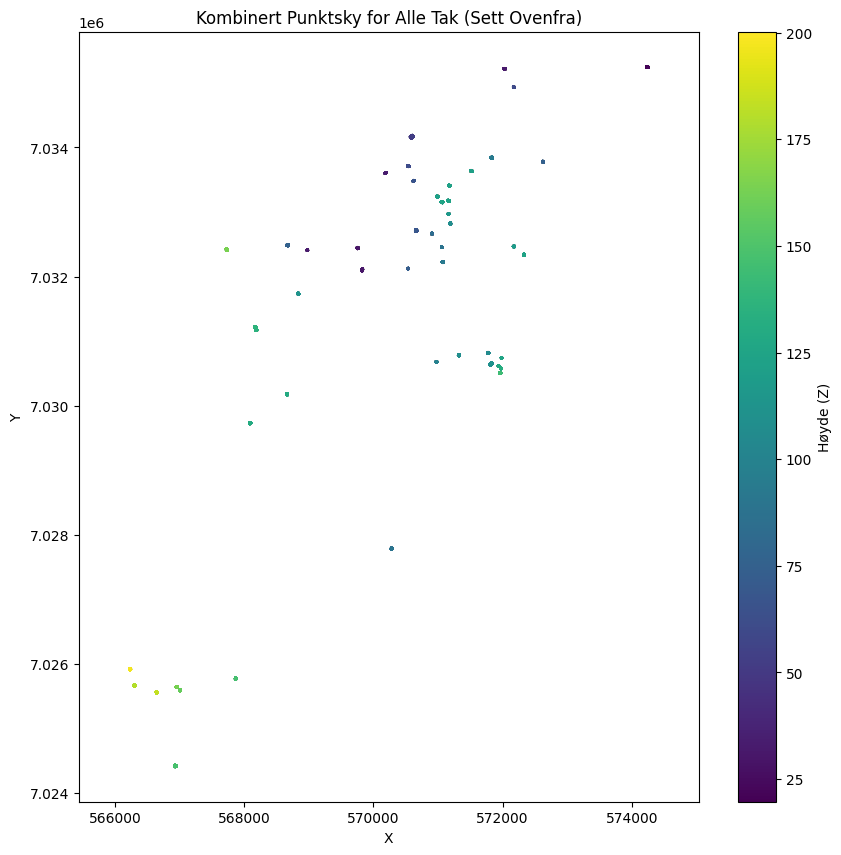

In [ ]:
import os
import laspy as lp
import matplotlib.pyplot as plt

folder = "sample_roofdata_50"

# Opprett lister for å samle alle punktene
all_x = []
all_y = []
all_z = []

# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        # Lag hele filstien ved å kombinere mappen og filnavnet
        file_path = os.path.join(folder, roof)
        
        # Åpne .laz-filen og les punktene
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z
            
            # Legg punktene til samlelistene
            all_x.extend(x)
            all_y.extend(y)
            all_z.extend(z)

# Plot alle takene i 2D (ovenfra)
plt.figure(figsize=(10, 10))
scatter = plt.scatter(all_x, all_y, c=all_z, s=1, cmap='viridis')  # Farger basert på høyde (z)
plt.title("All roofs in 2D")
plt.xlabel("X")
plt.ylabel("Y")

# Legg til en fargeskala for høyden
cbar = plt.colorbar(scatter)
cbar.set_label("Høyde (Z)")

plt.axis('equal')  # Sikrer at aksene har samme skala
plt.show()

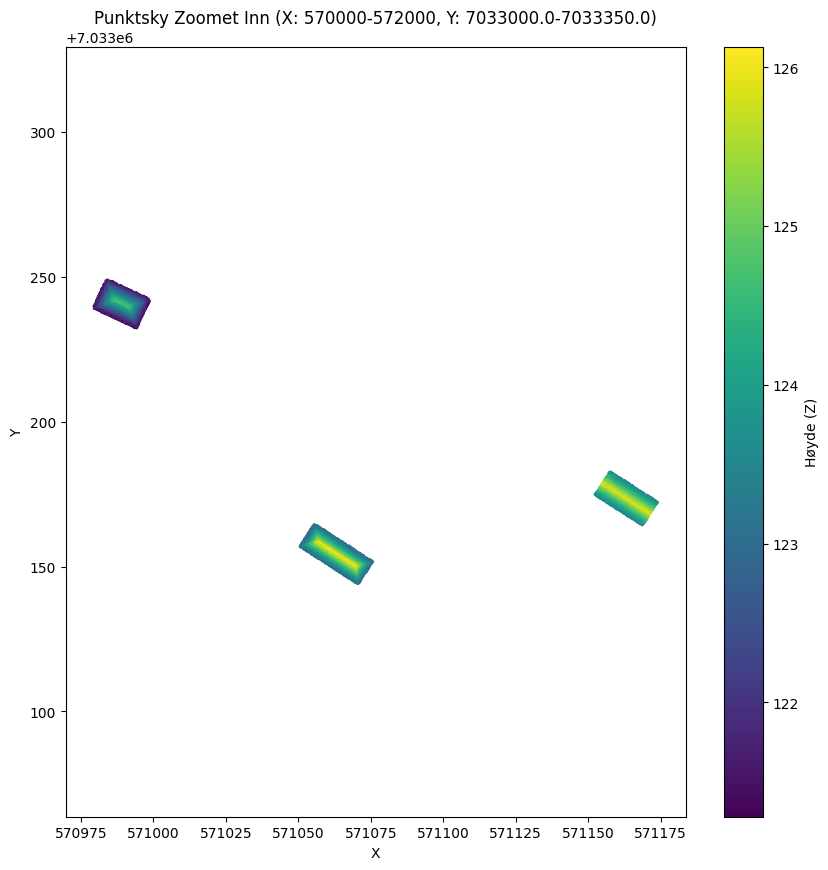

In [ ]:
import os
import laspy as lp
import matplotlib.pyplot as plt

folder = "sample_roofdata_50"

# Opprett lister for å samle alle punktene
all_x = []
all_y = []
all_z = []

# Gå gjennom filene i mappen
for roof in os.listdir(folder):
    if roof.endswith(".laz"):
        # Lag hele filstien ved å kombinere mappen og filnavnet
        file_path = os.path.join(folder, roof)
        
        # Åpne .laz-filen og les punktene
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z
            
            # Legg punktene til samlelistene
            all_x.extend(x)
            all_y.extend(y)
            all_z.extend(z)

# Definer området du vil zoome inn på
x_min, x_max = 570000, 572000  # Juster disse verdiene for ditt område
y_min, y_max = 7.0330e6, 7.03335e6

# Filtrer punkter som faller innenfor området
zoom_x = [x for x, y in zip(all_x, all_y) if x_min <= x <= x_max and y_min <= y <= y_max]
zoom_y = [y for x, y in zip(all_x, all_y) if x_min <= x <= x_max and y_min <= y <= y_max]
zoom_z = [z for x, y, z in zip(all_x, all_y, all_z) if x_min <= x <= x_max and y_min <= y <= y_max]

# Plot punktene i zoom-området
plt.figure(figsize=(10, 10))
scatter = plt.scatter(zoom_x, zoom_y, c=zoom_z, s=1, cmap='viridis')  # Farger basert på høyde (z)
plt.title(f"All roofs, zoomed in")
plt.xlabel("X")
plt.ylabel("Y")

# Legg til en fargeskala for høyden
cbar = plt.colorbar(scatter)
cbar.set_label("Høyde (Z)")

plt.axis('equal')  # Sikrer at aksene har samme skala
plt.show()